In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [2]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [4]:
del file_to_pages

In [5]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [6]:
df_annotations_num_arms_known = df_annotations_num_arms_known.sample(1000)

In [7]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

# Train and evaluate the number of arms extractor

In [8]:
sys.path.append("../../front_end")
from util.page_tokeniser import tokenise_pages, tokenise_text, tokenise_text_and_lowercase

In [9]:
import spacy
from spacy.matcher import Matcher
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'lemmatizer'])



In [10]:
word2num = {'one': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 'ten': 10,
 'eleven': 11,
 'twelve': 12,
 'thirteen': 13,
 'fourteen': 14,
 'fifteen': 15,
 'sixteen': 16,
 'seventeen': 17,
 'eighteen': 18,
 'nineteen': 19,
 'both': 2,
 'single': 2}

In [11]:
number_words = list(word2num)

In [12]:
for n in range(1, 20):
    word2num[str(n)]= n

In [13]:
numbers_above_3 = list([w for w in word2num if word2num[w] >= 3])

In [14]:
matcher = Matcher(nlp.vocab)
patterns = [ #[{"LIKE_NUM":True},  {"LOWER": {"IN": ["treatment", "study", "dose"]}, "OP":"?"}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
           [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["treatment", "study", "dose"]}}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
#            [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
             [{"LOWER":{"IN":list(word2num)}},{"LOWER":"-", "OP":"?"}, {"LOWER": {"IN": [ "armed"]}}],
        [{"LOWER":{"IN":["the", "with", "between", "of", "into", "to"]}}, {"LOWER":{"IN":list(word2num)}},{"LOWER":{"IN": ["treatment", "study", "dose"]}, "OP":"?"}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}]
]
matcher.add("arms", patterns)

In [15]:
doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=["5", "arms"])
matcher(doc)

[]

In [16]:
#tokenised_pages = [["5", "arms"]]
# if True:
def process(self, tokenised_pages: list) -> tuple:
    """
    Identify the trial phase.
    :param tokenised_pages: List of lists of tokens of each page.
    :return: The prediction (str) and a map from phase to the pages it's mentioned in.
    """

    tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

    phase_to_pages = {}

    for page_number, page_tokens in enumerate(tokenised_pages):
        doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=page_tokens)
        matches = matcher(doc)
        for word, start, end in matches:
            phase_number = doc[start:end]
            if phase_number not in phase_to_pages:
                phase_to_pages[phase_number] = []
            phase_to_pages[phase_number].append(page_number)

    phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: min(v[1]))

    prediction = 0
    if len(phase_to_pages) == 1 or \
        (len(phase_to_pages) > 1 and min(phase_to_pages[0][1]) < min(phase_to_pages[1][1])):
        for word in phase_to_pages[0][0]:
            if word.text in word2num:
                prediction = word2num[word.text]
                break
    if prediction > 5:
        prediction = 5
                
    phase_to_pages = [(phrase.text, value) for phrase, value in phase_to_pages]

    return {"prediction": prediction, "pages": dict(phase_to_pages)}

In [17]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [18]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import make_pipeline

In [20]:
VOCAB = {"assignment arm",
"single arm",
"experimental arm",
"two arms",
"study arms",
"control arm",
"placebo arm",
"both arms",
"three arm",
"treated arm",
"each arm",
"per arm",
"treatment arms",
"placebo arms",
"intervention arm",
"interventions arm",
"intervention arms",
"parallel arms",
"1 arm",
"chemotherapy arm",
"between arms",
"study arm",
"second arm",
"imaging arm",
"dose arm",
"control arms",
"3 arm",
"2 arm",
"active arms",
"comparator arm",
"vaccine arm",
"injection arm",
"vaccine arms",
"adjuvanted arms",
"across arms",
"boost arms",
"blinded arm",
"by arm",
"comparing arms",
"reference arms",
"two arm",
"therapy arms",
"three arms",
"interventional arm",
"observation arms",
"monotherapy arms",
"therapy arm",
"3 arms",
"combination arms",
"monotherapy arm",
"treatments arm",
"chemotherapy arms",
"radiation arms",
"all arms",
"measurement arm",
"radiotherapy arm",
"investigational arm",
"4 arm",
"radiation arm",
"immunotherapy arm",
"5 arms",
"5 arm",
"4 arms",
"doses arm",
"regimen arm",
"multiple arm",
"various arms",
"ii arm",
"iii arm",
"iv arm",
"vi arm",
"vii arm",
"viii arm",
"ix arm",
"cancer arm",
"excluded arm",
"carcinoma arm",
"observational arm",
"procedure arm",
"allocation arm",
"allocation arms",
"trial arm",
"independent arms",
"dosing arms",
"dosing arm",
"schedule arm",
"schedules arms",
"controlled arm",
"care arms",
"randomized arms",
"18 arm",
"single armed",
"one armed",
"response arm",
"multi arm",
"experimental arms",
"investigational arms",
"randomized arm",
"diabetic arms",
"diabetic arm",
"patient arms"}

In [21]:
for v in list(VOCAB):
    if "arm" in v:
        VOCAB.add(re.sub("arm", "cohort", v))

In [22]:
for i in word2num:
    VOCAB.add(f"{i} arm")
    VOCAB.add(f"{i} arms")
    VOCAB.add(f"{i} cohort")
    VOCAB.add(f"{i} cohorts")
    VOCAB.add(f"{i} armed")
    VOCAB.add(f"{i} study")
    VOCAB.add(f"{i} investigational")
    VOCAB.add(f"{i} dose")
    VOCAB.add(f"{i} treatment")

In [23]:
VOCAB = VOCAB.union({
                                "arm", "group", "subgroup", "cohort", "arms", "groups", "subgroups", "cohorts",
                    "randomise", "randomize", "randomisation", "randomization", "randomised", "randomized",
                    "placebo", "unblinded", "unblinding", "blinded", "blinding", "blind", "compare", "double",
                    "controlled", "control", "differences", "vs", "outcomes", "hypothesis", "experimental", "compared",
                    "effects", "variables", "variables", "ratio", "versus", "outcome", "monotherapy", "polytherapy", "proprietary",
                    "criterion", "healthy", "remission", "separately", "separate", "separated", "assay", "dosing", "dose", "doses",
                    "treatment", "treatments", "study", "studies", "either", "both",
                            "metastatic", "metastases", "metastasis", "measurable", "transplant",
                            "refractory","recist", "tumor", "insulin", "cognitive", "discharge",
                            "dsmb", "itt", "block","mortality", "scores", "questionnaire",
                            "recruitment", "power", "item", "controlled","participants", "children",
                            "side", "sided", "unit", "dmc", "alpha", "beta", "inflammatory",
                            "outcomes", "effects", "cardiac", "average", "significance",
                            "intervention","sap","adherence", "database", "primary", "standard", "trial",
                            "statistical", "factors", "significantly", "unscheduled", "amended",
                            "three", "two", "four", "five", "six", "seven", "eight", "nine"})

In [24]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True,
                             token_pattern=r'[a-z][a-z]+|\d+', 
                            ngram_range=[1,2],
                            vocabulary=VOCAB)
transformer = TfidfTransformer()

nb = MultinomialNB()
nb = ComplementNB()
model = make_pipeline(vectoriser, transformer, nb)

In [25]:
df_train.num_arms_clean.value_counts()

2.0    343
1.0    212
3.0    118
5.0     67
4.0     65
Name: num_arms_clean, dtype: int64

In [42]:
model.fit(df_train.text, df_train.num_arms_clean)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=[1, 2],
                                 token_pattern='[a-z][a-z]+|\\d+',
                                 vocabulary={'1 arm', '1 armed', '1 arms',
                                             '1 cohort', '1 cohorts', '1 dose',
                                             '1 investigational', '1 study',
                                             '1 treatment', '10 arm',
                                             '10 armed', '10 arms', '10 cohort',
                                             '10 cohorts', '10 dose',
                                             '10 investigational', '10 study',
                                             '10 treatment', '11 arm',
                                             '11 armed', '11 arms', '11 cohort',
                                             '11 cohorts', '11 dose',
                                             '11 investigational', '11 study',
                                             '11 treatment', '12 arm',
                                             '12 armed', '12 arms', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('complementnb', ComplementNB())])

In [43]:
#df_val["pred_num_arms_nb"]  = model.predict(df_val.text.apply(lambda t : " ".join(t)))
df_val["pred_num_arms_nb"]  = model.predict(df_val.text)

/tmp/ipykernel_7891/2795239110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms_nb"]  = model.predict(df_val.text)


In [44]:
df_val.pred_num_arms_nb.value_counts()

2.0    67
1.0    28
5.0     1
Name: pred_num_arms_nb, dtype: int64

In [45]:
def get_num_arms_and_pages(text):
    pages = [text]
    toks = tokenise_pages(pages)
    result = process(None, toks)
    return result

In [46]:
spacy_output = df_val.text.apply(get_num_arms_and_pages)
df_val["pred_num_arms_spacy"] = spacy_output.apply(lambda x : x["prediction"])
df_val["pages"] = spacy_output.apply(lambda x : x["pages"])

/tmp/ipykernel_7891/1696606368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms_spacy"] = spacy_output.apply(lambda x : x["prediction"])
/tmp/ipykernel_7891/1696606368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pages"] = spacy_output.apply(lambda x : x["pages"])


In [47]:
df_val["pred_num_arms_spacy"].value_counts()

0    80
2    14
5     2
Name: pred_num_arms_spacy, dtype: int64

In [48]:
pred_num_arms = []
for i in range(len(df_val)):
    if df_val.pred_num_arms_spacy.iloc[i] > 0:
        pred = df_val.pred_num_arms_spacy.iloc[i]
    else:
        pred = df_val.pred_num_arms_nb.iloc[i]
    pred_num_arms.append(pred)
df_val["pred_num_arms"] = pred_num_arms
pred_num_arms= df_val["pred_num_arms"]

/tmp/ipykernel_7891/521656970.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms"] = pred_num_arms


In [49]:
pred_num_arms

920      2.0
6088     2.0
8838     1.0
11672    1.0
3082     2.0
        ... 
4940     2.0
10248    1.0
988      2.0
227      2.0
4578     5.0
Name: pred_num_arms, Length: 96, dtype: float64

In [50]:
pred_num_arms.value_counts()

2.0    69
1.0    25
5.0     2
Name: pred_num_arms, dtype: int64

In [51]:
num_arms_ground_truths = df_val.num_arms_clean

In [52]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.5416666666666666


''

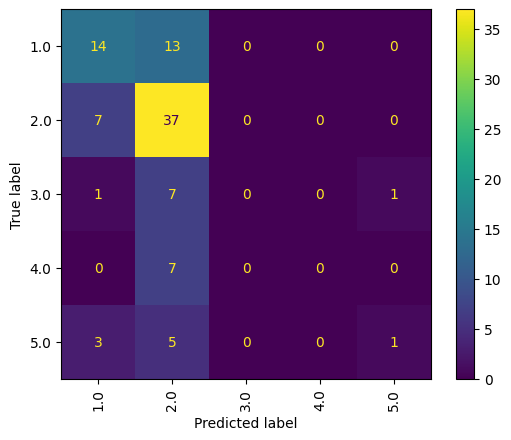

In [53]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;

In [54]:
accuracy_score(num_arms_ground_truths[pred_num_arms > 0], pred_num_arms[pred_num_arms > 0])

0.5416666666666666

In [55]:
for i in range(len(df_val)):
    print (df_val.num_arms_clean.iloc[i], df_val.pages.iloc[i])

2.0 {'the two cohorts': [0]}
2.0 {'both treatment arms': [0], 'the two groups': [0]}
2.0 {'two treatment arms': [0], 'the two treatment arms': [0]}
1.0 {}
2.0 {'three dose groups': [0], 'the three dose groups': [0], 'both treatment groups': [0]}
5.0 {'five treatment groups': [0], 'of five treatment groups': [0], 'into 5 treatment groups': [0], 'two treatment groups': [0], 'into two groups': [0], 'the two treatment groups': [0], 'of two groups': [0], 'the two groups': [0], 'two dose groups': [0], 'the two dose groups': [0], 'four treatment groups': [0], 'to 3 group': [0]}
2.0 {'of 2 treatment groups': [0], 'to both groups': [0], 'both treatment groups': [0], 'to both treatment groups': [0]}
2.0 {'of 2 arms': [0], 'between two groups': [0]}
2.0 {}
3.0 {'into two cohorts': [0], 'two treatment arms': [0], 'the two treatment arms': [0], 'two treatment groups': [0], 'the two treatment groups': [0], 'the 2 treatment arms': [0], 'the two groups': [0]}
2.0 {}
1.0 {'with 2 cohorts': [0], 'the 3 

In [56]:
df_val

,file,nct_id,train_val,num_arms,num_subjects,phase,intervention_type,country,has_sap,text,num_arms_clean,pred_num_arms_nb,pred_num_arms_spacy,pages,pred_num_arms
920,07_NCT03883607_Prot_000.pdf,NCT03883607,val,2.0,NaN,Phase 2,Drug,US,0,\nCli ni c al Tri al G F T 5 0 5 E -2 1 8 -1 ...,2.0,2.0,0,{'the two cohorts': [0]},2.0
6088,51_NCT01826851_Prot_SAP_000.pdf,NCT01826851,val,2.0,NaN,Phase 2,Drug,US,1,\nParasternal intercostal nerve block in cardi...,2.0,2.0,0,"{'both treatment arms': [0], 'the two groups':...",2.0
8838,74_NCT02823574_Prot_000.pdf,NCT02823574,val,2.0,NaN,Phase 2,Biological,"US,AR,BE,BR,CA,CL,CZ,FI,FR,IE,IT,MX,NL,NO,RO,R...",0,\n \nClinical Protocol CA209714\nBMS-936558 ni...,2.0,1.0,0,"{'two treatment arms': [0], 'the two treatment...",1.0
11672,98_NCT01807598_Prot_SAP_000.pdf,NCT01807598,val,1.0,NaN,Phase 2,Drug,US,1,\n \n\n \nA study of brentuximab vedotin (SGN...,1.0,1.0,0,{},1.0
3082,25_NCT04805125_Prot_SAP_000.pdf,NCT04805125,val,2.0,NaN,Phase 3,Biological,CH,1,\nClinical Study first sub-protocol \n \n\nRan...,2.0,2.0,0,"{'three dose groups': [0], 'the three dose gro...",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,41_NCT02859441_Prot_000.pdf,NCT02859441,val,1.0,NaN,Phase 1/Phase 2,Drug,US,0,"\nER-VHL November 7, 2018 \n \n\nVersion 7.0 C...",1.0,2.0,2,{'the two groups': [0]},2.0
10248,86_NCT01889186_Prot_000.pdf,NCT01889186,val,2.0,NaN,Phase 2,Drug,"US,AU,CA,FR,DE,PL,GB",0,\nNCT01889186\n\n \nVenetoclax (ABT-199)\nM13-...,2.0,1.0,0,{},1.0
988,08_NCT02814708_Prot_SAP_000.pdf,NCT02814708,val,7.0,NaN,Phase 2,Biological,AT,1,\nrTSST-1 Variant Vaccine Phase 2/ BioMED 0515...,5.0,2.0,0,"{'of seven groups': [0], 'of two groups': [0]}",2.0
227,01_NCT03852901_Prot_SAP_000.pdf,NCT03852901,val,1.0,NaN,Phase 1,Drug,US,1,\n \n\nCLINICAL RESEARCH PROTOCOL \nNATIONAL I...,1.0,2.0,0,{},2.0


In [57]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")

Strongest predictors for class 0

0	cohort
1	dose
2	cohorts
3	treatment
4	single arm
5	study
6	nine
7	two cohort
8	eight
9	six
10	monotherapy
11	metastasis
12	transplant
13	four
14	refractory
15	metastatic
16	ii arm
17	tumor
18	measurable
19	metastases
20	two dose
21	recist
22	treated cohort
23	remission
24	2 dose
25	dose cohort
26	three
27	dosing
28	3 dose
29	7 investigational
30	five
31	4 dose
32	8 dose
33	7 dose
34	5 dose
35	control cohort
36	doses
37	vaccine cohort
38	three dose
39	5 investigational
40	patient cohorts
41	11 study
42	children
43	interventional cohort
44	one dose
45	proprietary
46	four dose
47	1 investigational
48	observational arm
49	assay
50	1 dose
51	both
52	single study
53	8 investigational
54	4 treatment
55	dosing arm
56	amended
57	2 study
58	6 dose
59	6 investigational
60	studies
61	10 dose
62	2 investigational
63	5 treatment
64	3 cohort
65	3 treatment
66	cardiac
67	9 investigational
68	3 investigational
69	15 dose
70	one armed
71	1 study
72	comparator cohort
7

0	arm
1	arms
2	experimental
3	randomized
4	treatment
5	study
6	placebo
7	two
8	seven
9	blinded
10	itt
11	two treatment
12	study arm
13	control
14	block
15	both
16	control arm
17	insulin
18	two arms
19	controlled
20	one arm
21	scores
22	randomization
23	intervention
24	five
25	both treatment
26	questionnaire
27	dsmb
28	compare
29	both arms
30	discharge
31	cognitive
32	vs
33	subgroup
34	randomize
35	blind
36	unblinding
37	side
38	double
39	item
40	mortality
41	variables
42	alpha
43	versus
44	outcomes
45	2 arm
46	power
47	investigational arm
48	groups
49	each arm
50	recruitment
51	trial
52	effects
53	study arms
54	average
55	compared
56	treatment arms
57	beta
58	inflammatory
59	adherence
60	differences
61	ratio
62	randomised
63	group
64	sided
65	second arm
66	hypothesis
67	unblinded
68	randomisation
69	experimental arm
70	significance
71	unit
72	outcome
73	blinding
74	significantly
75	treatments
76	standard
77	2 treatment
78	primary
79	factors
80	participants
81	database
82	either
83	stat

0	four treatment
1	17 study
2	14 arms
3	15 arm
4	19 cohort
5	controlled arm
6	four arms
7	blinded arm
8	comparing cohorts
9	comparing arms
10	eleven investigational
11	various cohorts
12	one cohorts
13	chemotherapy cohorts
14	chemotherapy arms
15	care cohorts
16	procedure arm
17	one arms
18	one cohorted
19	observation arms
20	procedure cohort
21	nine treatment
22	nineteen arm
23	nineteen armed
24	nineteen arms
25	nineteen cohort
26	nineteen cohorts
27	observation cohorts
28	nineteen dose
29	diabetic cohorts
30	diabetic cohort
31	diabetic arms
32	diabetic arm
33	nineteen study
34	nineteen treatment
35	nineteen investigational
36	radiation arms
37	vi cohort
38	nine investigational
39	seventeen armed
40	7 armed
41	7 arms
42	seventeen arm
43	seven treatment
44	seven study
45	seven investigational
46	8 armed
47	8 arms
48	seven cohort
49	seven arms
50	9 armed
51	9 arms
52	seven armed
53	seven arm
54	twelve investigational
55	active cohorts
56	boost cohorts
57	boost arms
58	blinded cohort
59	